In [1]:
import os
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.autograd as autograd
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import wandb

# Датасет, гиперпараметры, модели

In [2]:
from dataset import ArchNegatives, ArchPositives
from train_encoder_izif import train_encoder_izif
from model_conv import Generator, Discriminator
from model_encoder import Encoder

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
params = {
    'batch_size': 1,
    'channels': 3,
    'img_size': 256,
    'latent_dim': 100,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'n_epochs': 200,
    'n_critic': 5,
    'sample_interval': 400,
}

In [6]:
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
train_dataset = ArchNegatives(transform=transform_base)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchPositives(transform=transform_base)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [8]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 139945 images, 139945 batches
anomalies: 163 images, 163 batches


In [9]:
generator = Generator(params)
discriminator = Discriminator(params)
encoder = Encoder(params)

In [10]:
generator.load_state_dict(torch.load("train_wgan/results_conv_256/generator", map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load("train_wgan/results_conv_256/discriminator", map_location=torch.device('cpu') ))
encoder.load_state_dict(torch.load("train_izif_encoder/results_encoder_256/encoder", map_location=torch.device('cpu') ))

<All keys matched successfully>

In [11]:
generator.to(device).eval();
discriminator.to(device).eval();
encoder.to(device).eval();

# Модель сравнения изображений

In [25]:
criterion = nn.MSELoss()
kappa=5.0

# with open("score.csv", "w") as f:
#     f.write("label,img_distance,anomaly_score,z_distance\n")

In [26]:
def test(img):
    
    real_img = img.to(device)
    real_z = encoder(real_img)
    fake_img = generator(real_z)
    fake_z = encoder(fake_img)

    real_feature = discriminator.forward_features(real_img)
    fake_feature = discriminator.forward_features(fake_img)

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)
    anomaly_score = img_distance + kappa * loss_feature

    z_distance = criterion(fake_z, real_z)
    
    return fake_img, img_distance.item(), anomaly_score.item(), z_distance.item(), loss_feature.item()
    
    # with open("results/score.csv", "a") as f:
    #     f.write(f"{label.item()},{img_distance},"
    #             f"{anomaly_score},{z_distance}\n")
    

In [21]:
N = 1000

mean_img_dist = 0
mean_loss_feature = 0

for i in tqdm(range(1000)):
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(train_dataset[i][0][None, :, :, :])
    mean_img_dist += img_distance
    mean_loss_feature += loss_feature
  
mean_img_dist /= N
mean_loss_feature /= N

100%|██████████| 1000/1000 [01:07<00:00, 14.83it/s]


In [22]:
mean_img_dist, mean_loss_feature

(0.033805277829989794, 0.003633727194799576)

In [24]:
 mean_img_dist / mean_loss_feature

9.303196420020292

# Смотрим, как восстанавливаются картинки

## Train dataset

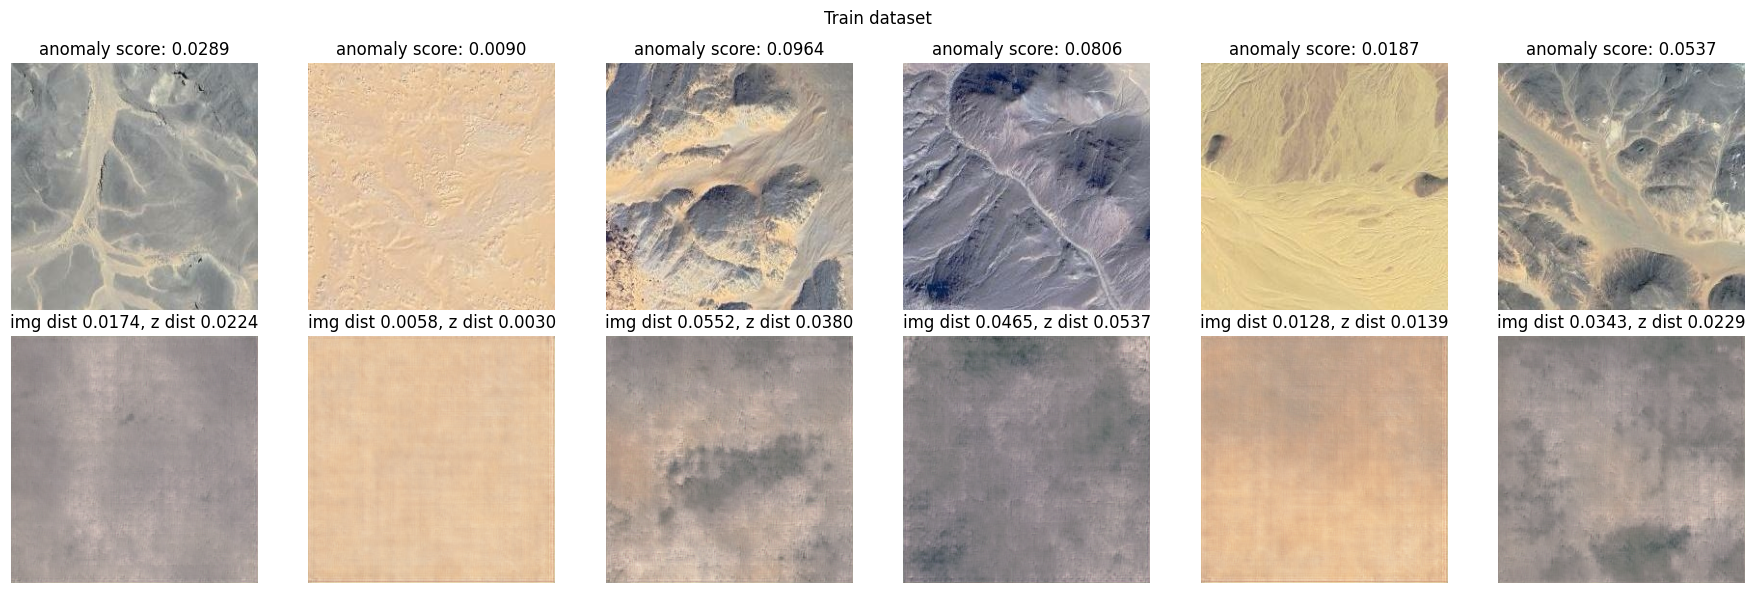

In [27]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[j]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

In [ ]:
nrows, ncols = 2, 100

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[j]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

## Anomalies dataset

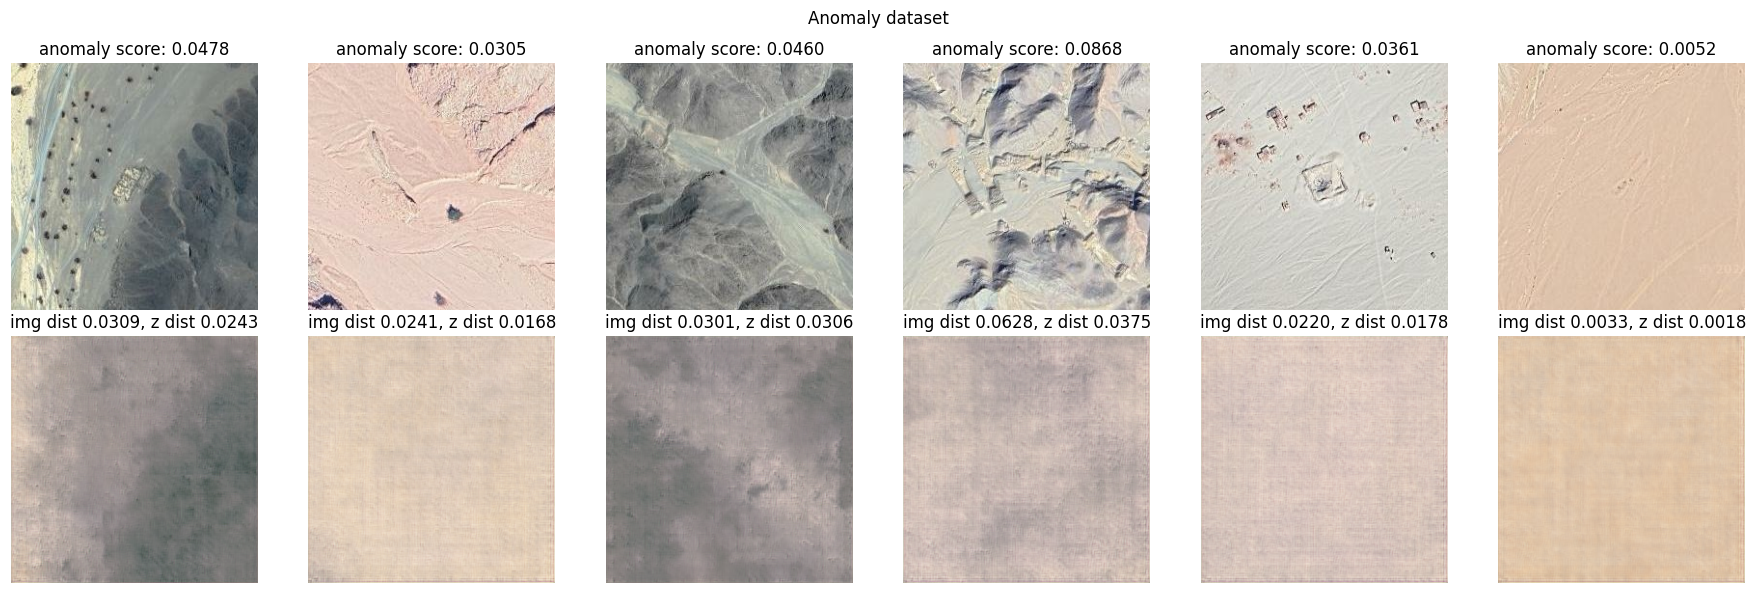

In [31]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[j]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

In [ ]:
nrows, ncols = 2, 100

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[j + 6]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

# Самые аномальные картинки

## Anomalies dataset

In [ ]:
anomaly_scores = {}

for i in tqdm(range(len(anomalies_dataset))):
    img, label = anomalies_dataset[i]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)
    anomaly_scores[i] = anomaly_score
    
anomaly_scores_sorted = sorted([(score, i) for (i, score) in anomaly_scores.items()])

100%|██████████| 163/163 [00:10<00:00, 15.65it/s]


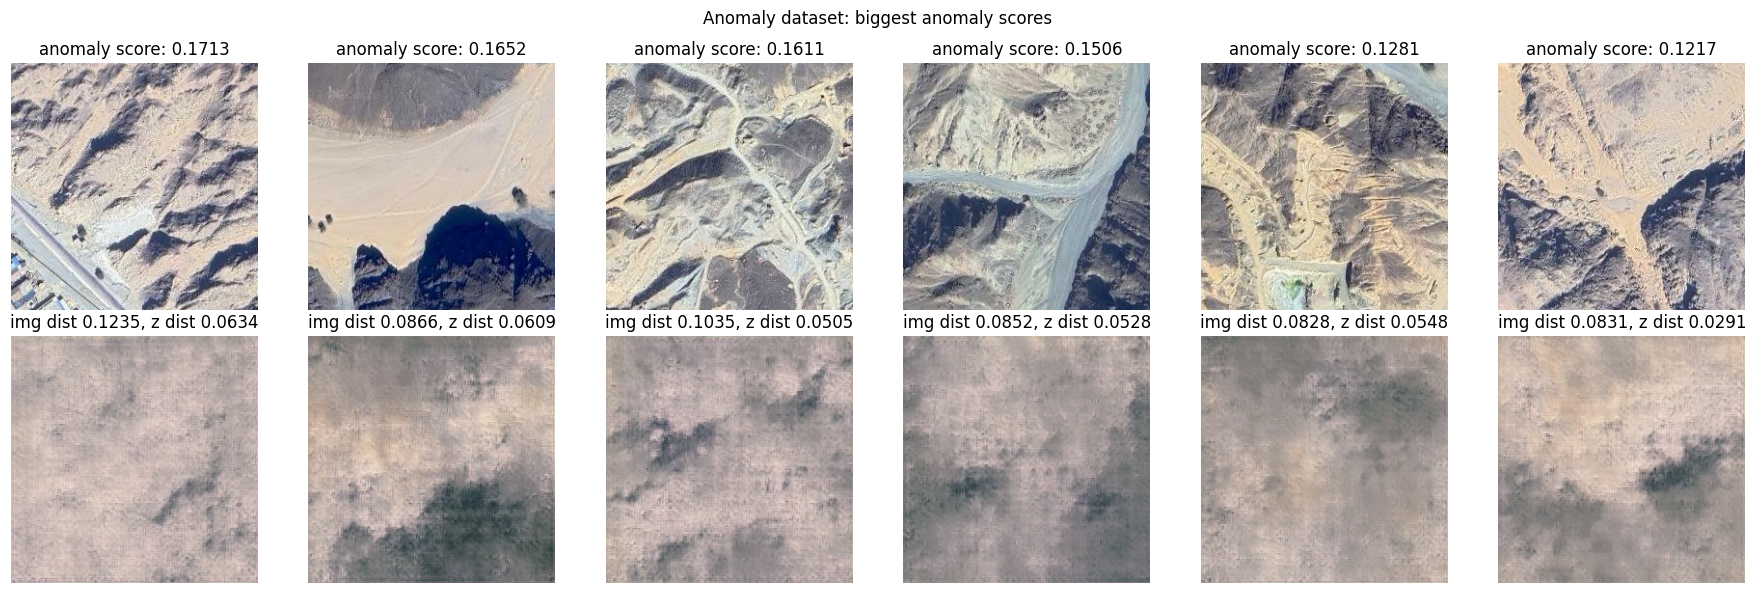

In [ ]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset: biggest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_sorted[len(anomaly_scores_sorted) - 1 - j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

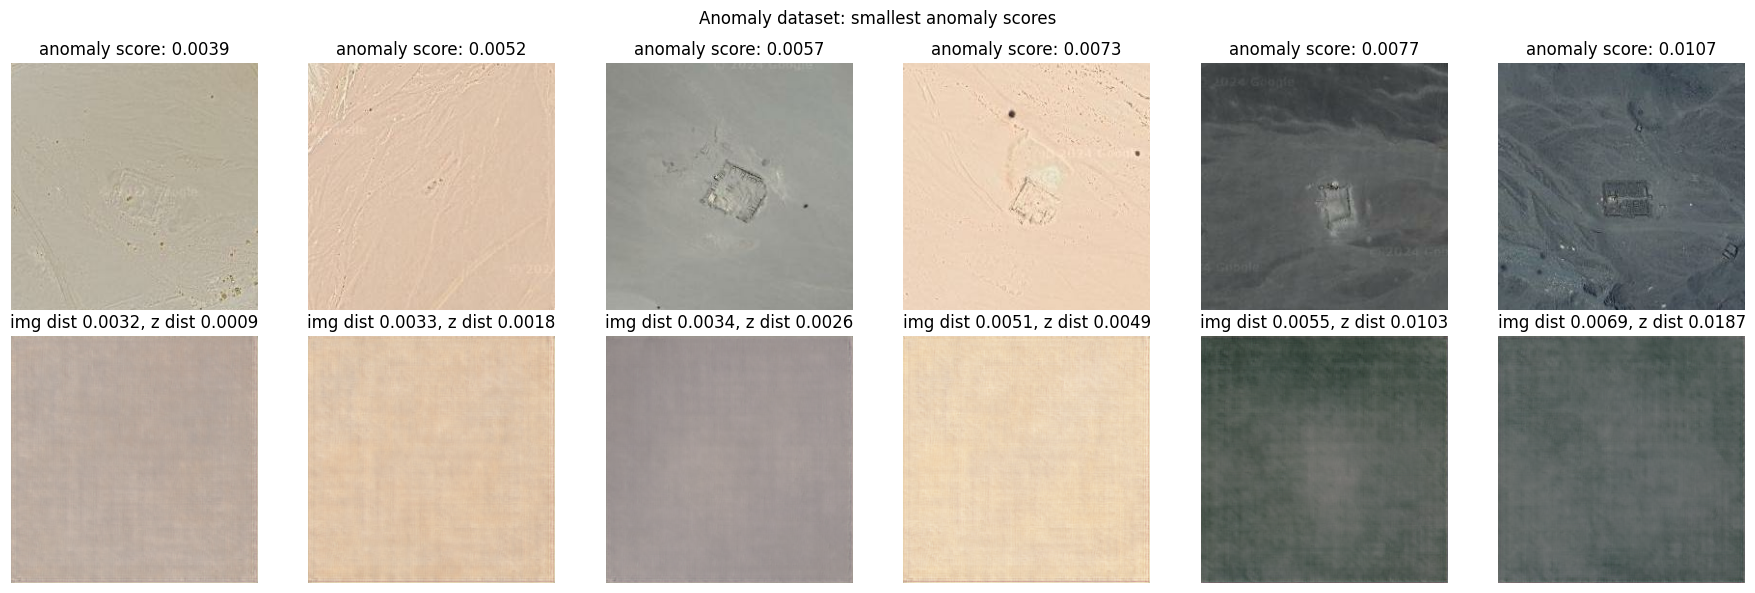

In [ ]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset: smallest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_sorted[j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

fig.savefig('least_suspicious')

## Train dataset

In [36]:
anomaly_scores_train = {}

for i in tqdm(range(len(train_dataset))):
    img, label = train_dataset[i]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)
    anomaly_scores_train[i] = anomaly_score

100%|██████████| 139945/139945 [2:31:12<00:00, 15.42it/s]  


In [37]:
anomaly_scores_train_sorted = sorted([(score, i) for (i, score) in anomaly_scores_train.items()])

In [38]:
anomaly_scores_lst = [score for (score, i) in anomaly_scores_sorted]
anomaly_scores_train_lst = [score for (score, i) in anomaly_scores_train_sorted]

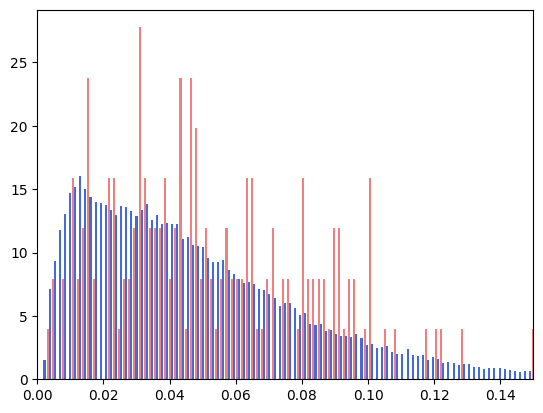

In [39]:
plt.hist([anomaly_scores_lst, anomaly_scores_train_lst], bins=400, color=['lightcoral', 'royalblue'], density=True);
plt.xlim([0, 0.15]);
# plt.hist(anomaly_scores_train_lst, bins=100, color='royalblue');
plt.savefig('hist');

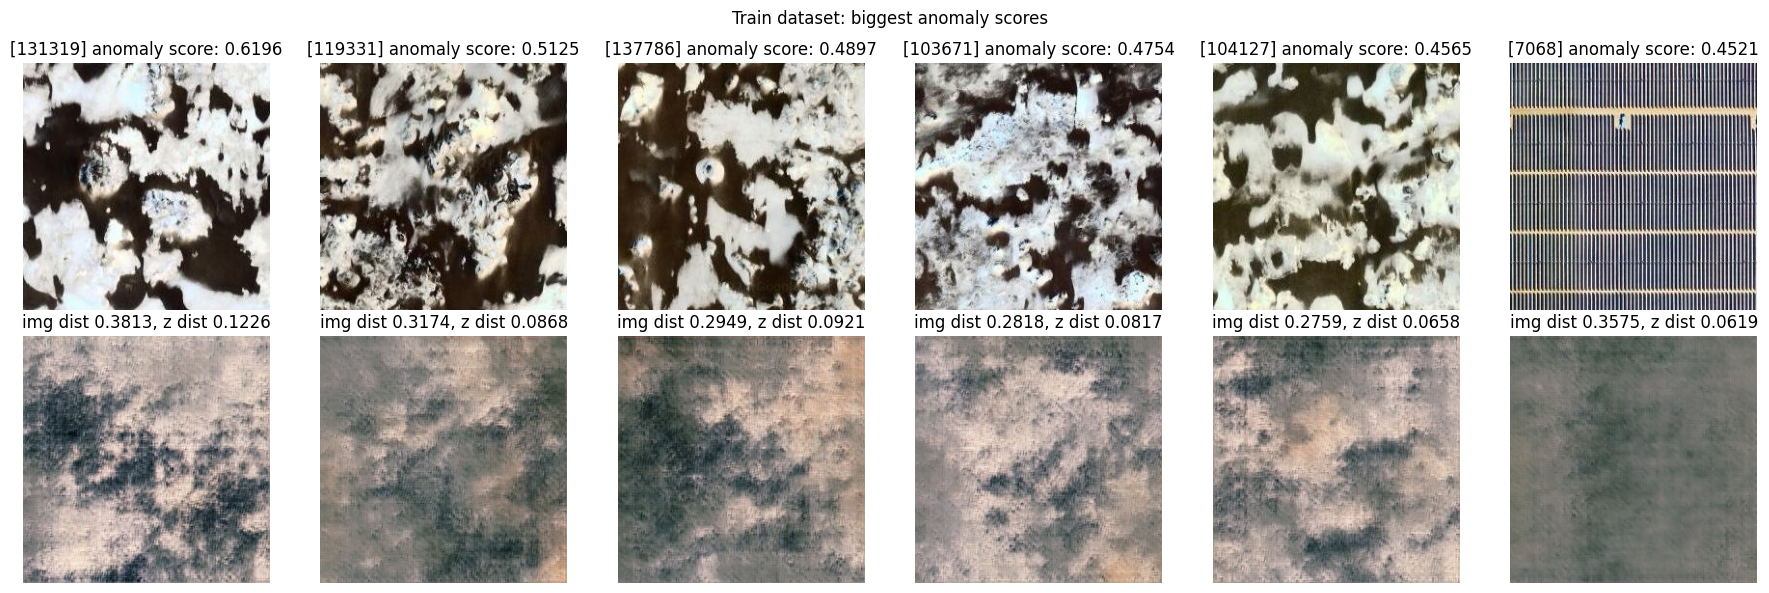

In [40]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: biggest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[len(anomaly_scores_train_sorted) - 1 - j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'[{ind_in_dataset}] anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

In [ ]:
nrows, ncols = 2, 200

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: biggest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[len(anomaly_scores_train_sorted) - 1 - j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'[{ind_in_dataset}] anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

In [41]:
i = 109337  # 136677, 68927, 56282, 109337
print(train_dataset.get_coords(i))
train_dataset[i][0]

(25.7244467526159, 33.905181884765625)


tensor([[[0.9843, 0.9843, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         [0.9843, 0.9843, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.9765, 0.9765, 0.9843,  ..., 0.9843, 1.0000, 0.9608],
         [0.9608, 0.9608, 0.9765,  ..., 0.9765, 0.9843, 0.9765],
         [0.9451, 0.9529, 0.9686,  ..., 0.8902, 0.8980, 0.9451]],

        [[0.7098, 0.7098, 0.7020,  ..., 0.7333, 0.7333, 0.7333],
         [0.7098, 0.7098, 0.7020,  ..., 0.7333, 0.7333, 0.7333],
         [0.7020, 0.7020, 0.7020,  ..., 0.7333, 0.7333, 0.7333],
         ...,
         [0.7333, 0.7412, 0.7255,  ..., 0.7490, 0.7725, 0.7255],
         [0.7176, 0.7255, 0.7176,  ..., 0.7412, 0.7490, 0.7412],
         [0.7020, 0.7176, 0.7098,  ..., 0.6549, 0.6627, 0.7098]],

        [[0.2078, 0.2078, 0.2078,  ..., 0.1765, 0.1765, 0.1765],
         [0.2078, 0.2078, 0.2078,  ..., 0.1765, 0.1765, 0.1765],
         [0.2078, 0.2078, 0.2078,  ..., 0.1765, 0.1765, 0.

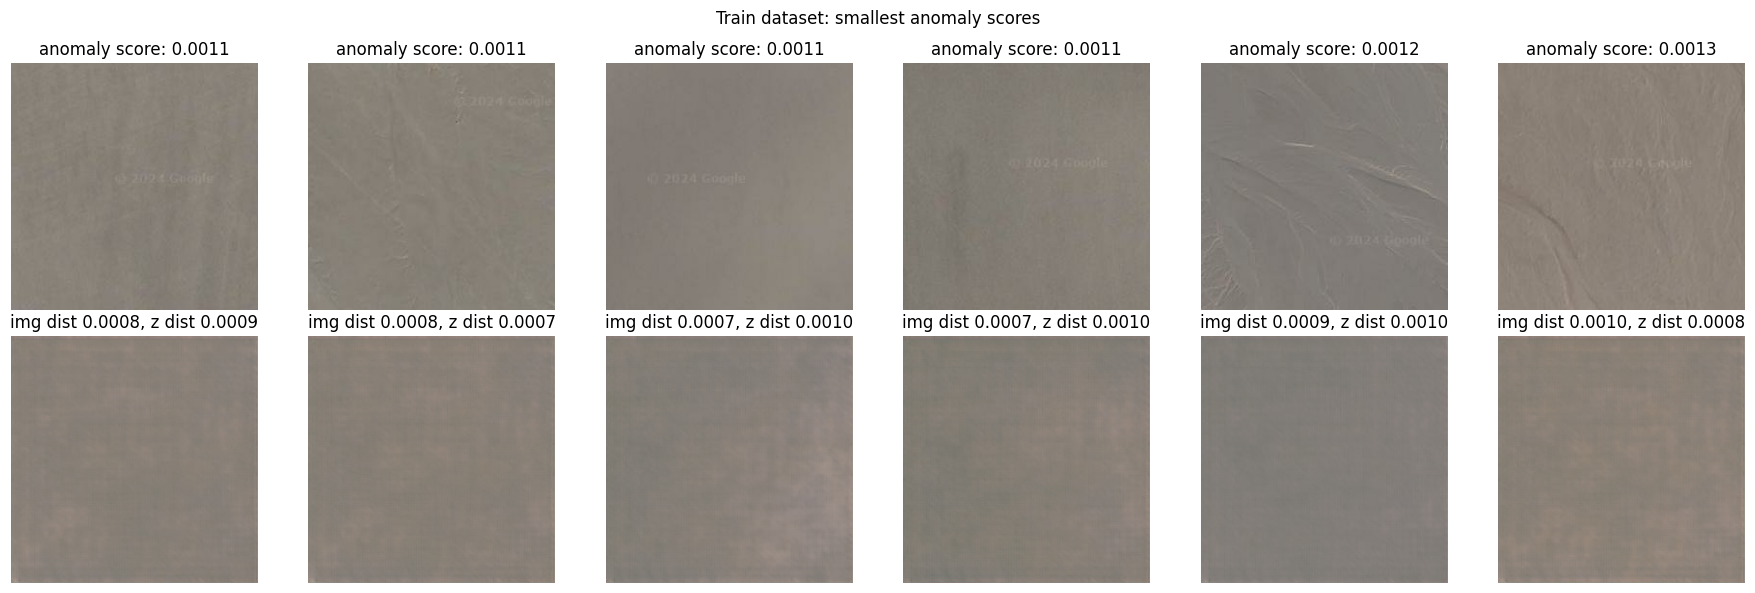

In [42]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: smallest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

In [ ]:
nrows, ncols = 2, 200

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: smallest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance, loss_feature = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()